<h1>Predicting Missing Stock Prices with IterativeImputer</h1>
<h3 style="color:gray">Replacing past history stock prices with NaN and then using sklearn's IterativeImputer to guess what value it was</h3>
<h4>An example, and yet another tutorial on another use case for IterativeImputer, in addition to my <a href="https://gifari.medium.com/a-better-way-to-handle-missing-values-in-your-dataset-using-iterativeimputer-9e6e84857d98">Medium article</a></h4>

[Gifari Hoque](https://gifari.github.io) - October 2021

# Table of Contents<a id="toc"></a>
#### 1. [An Introduction](#1)
   - 1.1 [What to Expect in this Notebook](#1.1)
   - 1.2 [A Brief Introduction to yfinance](#1.2)
   - 1.3 [A Brief Introduction to IterativeImputer](#1.3)
   - 1.4 [How to be the "Chosen One"](#1.4)
   - 1.5 [The Process Behind the Iterations](#1.5)
   
#### 2. [Here is Where the Action Starts](#2)
   - 2.1 [Importing Packages](#2.1)
   - 2.2 [Downloading the Historical Data for Google Using yfinance](#2.2)
       - 2.2.1 [The Data So Far](#2.2.1)
       - 2.2.2 [Understanding The Data So Far](#2.2.2)
           - 2.2.2.1 [Learning Your Military Time](#2.2.2.1)
           - 2.2.2.2 [But what do the Columns Stand for?](#2.2.2.2)
   - 2.3 [Converting the Layout](#2.3)
       - 2.3.1 [<b>FUNCTION:</b> splitDataByDates](#2.3.1)
       - 2.3.2 [Having 60 Dates](#2.3.2)
       - 2.3.3 [Making a Dictionary](#2.3.3)
           - 2.3.3.1 [<b>FUNCTION:</b> makeTimesDict](#2.3.3.1)
           - 2.3.3.2 [Adding Keys to our Dictionary](#2.3.3.2)
           - 2.3.3.3 [<b>FUNCTION:</b> appendValues](#2.3.3.3)
           - 2.3.3.4 [Making our Dictionary Valuable](#2.3.3.4)
           - 2.3.3.5 [Dataframe It!](#2.3.3.5)
           - 2.3.3.6 [Our New Layout](#2.3.3.6)
   - 2.4 [Replacing Random Values with `NaN`](#2.4)
       - 2.4.1 [<b>FUNCTION:</b> replaceWithNan](#2.4.1)
       - 2.4.2 [Machines Can Get Confused Too](#2.4.2)
       - 2.4.3 [Results After Replacement](#2.4.3)
   - 2.5 [Imputing Missing Values with IterativeImputer](#2.5)
       - 2.5.1 [<b>FUNCTION:</b> imputeMissingVals](#2.5.1)
       - 2.5.2 [After the Imputation](#2.5.2)
   - 2.6 [The Results](#2.6)
       - 2.6.1 [<b>FUNCTION:</b> displayResults](#2.6.1)
       - 2.6.2 [The Results are in](#2.6.2)
       - 2.6.3 [Understanding The Results](#2.6.3)

#### 3. [A Thank You](#3)
   - 3.1 [Final Words](#3.1)
   - 3.2 [All Functions](#3.2)
   - 3.3 [References](#3.3)

# 1. Introduction<a id="1"></a>
Chances are, you've read my Medium article and that's probably why you're here. If you don't know what I'm talking about, then please go ahead and check out my [Medium article by clicking here](https://gifari.medium.com/a-better-way-to-handle-missing-values-in-your-dataset-using-iterativeimputer-9e6e84857d98), where I go more in depth on what I'll be doing in this notebook! If you don't have access to Medium, that's fine as well, I'll still go over in detail on what I will be doing and I'll have some parts of my explanation from my article pasted in here as well.

This notebook is pretty much exactly what I've demonstrated in my Medium article, except here, I've created functions to make your life easier. 

### 1.1 What to Expect in this Notebook<a id="1.1"></a>

Here is a brief summary of what I will be doing:<br>
1. First I'm going to grab the historical market data of a stock information using the package <i>yfinance</i>.
2. I will then convert the original layout that is retrieved from yfinance into a layout of my own.
3. Next, I'm going to randomly replace a certain percentage of the data with `NaN`.
4. After that, I'm going to use `IterativeImputer()` to impute the missing values.
5. Finally, I'll display the results to compare the original price vs. the imputed price of the stock.

That's literally all! It's going to be a short notebook, but hopefully you guys learn something out of it and find it useful in your lives!

Without further ado, let's get started.

### 1.2 A Brief introduction to yfinance<a id="1.2"></a>

yfinance is a package used to download historical market data of stocks from [Yahoo! Finance](https://finance.yahoo.com/). It was developed by [Ran Aroussi](https://aroussi.com/) and is maintained by himself along with [other contributors](https://github.com/ranaroussi/yfinance/graphs/contributors). To learn more about yfinance, [click here](https://pypi.org/project/yfinance/) to view the documentation on PyPi and [click here](https://aroussi.com/post/python-yahoo-finance) to view the documentation on Ran Aroussi's page. You can also see the source code on GitHub by [clicking here](https://github.com/ranaroussi/yfinance).

You can install yfinance by running `pip install yfinance` or by downloading from [PyPi](https://pypi.org/project/yfinance/#files), or by cloning/downloading from [GitHub](https://github.com/ranaroussi/yfinance).

I have to say, even after using yfinance for this notebook, definitely play around with it and see what else you can do with it. It's definitely a convenient way to obtain the stock market data.


For this example, you'll need to have yfinance installed. To install yfinance on Kaggle, you can simply run the code below. It takes like a few seconds to install it.<br>
If you already have yfinance installed, you can skip this step.

In [69]:
!pip install yfinance

### 1.3 A Brief Introduction to IterativeImputer<a id="1.3"></a>

Iterative Imputer is a multivariate imputing strategy which models a column with the missing values (target variable) as a function of other features (predictor variables) in a [round-robin fashion](https://scikit-learn.org/stable/modules/impute.html#:~:text=It%20does%20so%20in%20an%20iterated%20round-robin%20fashion), and uses that estimate for imputation. The source code can be found on GitHub by [clicking here](https://github.com/scikit-learn/scikit-learn/blob/844b4be24/sklearn/impute/_iterative.py).

There are a number of parameters that you can see in [IterativeImputer's documentations](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html#:~:text=impute%20import%20IterativeImputer-,Parameters,-estimatorestimator%20object%2C%20default). It requires no parameter input as the default parameters are already set for you, meaning that, after you finish importing necessary packages, you can simply introduce an Iterative Imputer by running: `imp = IterativeImputer()`.

The default estimator used when doing <i>scikit-learn's</i> `IterativeImputer` is the <i>`BayesianRidge()`</i> estimator.

I'll be using the default estimator for this example. Feel free to try out your own!<br><br>
><b>Note:</b> This estimator is still <b>experimental</b> for now: the predictions and the API might change without any deprecation >cycle. To use it, you need to explicitly import `enable_iterative_imputer`.<br>
>To learn more about `IterativeImputer`, click [here](https://scikit->learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html).

<br><br>Because Iterative Imputer is a multivariate imputing method, it's dealing with multiple features. So how exactly does `IterativeImputer` know which feature to choose first to impute missing values for? That is a good question, and I'll address that in the following section.

### 1.4 How to be the "Chosen One"<a id="1.4"></a>


The "current feature" is chosen based on the `imputation_order` given where the default order is "ascending,." This means that the feature <i>chosen</i> first will be the feature containing the least missing values. After imputing all missing values in the chosen feature, the feature no longer contains missing values, so it is no longer the feature with the <i>least</i> missing values, hence the imputer will move onto the next feature with the least missing values.

The other orders are:
- descending: features with most missing values to fewest
- roman: left to right
- arabic: right to left
- random: a random order for each round


### 1.5 The Process Behind the Iterations<a id="1.5"></a>

Now that you know how to be the Chosen One, let's understand the process behind the iterations.<br>
Iterative Imputer initially initializes the missing values with the value passed for `initial_strategy`, where the initial strategy is the "mean" for each feature.<br>
The imputer then uses an estimator (where the default estimator used is [Bayesian Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.BayesianRidge.html)) at each step of the round-robin imputation. At each step, a feature column is chosen as the target variable `y` and the other feature columns are treated as predictor variables `X`. The missing values are then predicted for each features. This process is repeated for at most `max_iter` number of times, where the default is 10 times (rounds). The reason why I say "at most" and not "exactly" is because early stopping is enabled due to the default parameterization of `sample_posterior=False`. <br>

> The stopping criterion is met once<br>
> `max(abs(X_t - X_{t-1}))/max(abs(X[known_vals])) < tol`, <br>
> where `X_t` is `X` <i>at iteration</i> `t`.

This essentially means that for a single missing value, there are at most `max_iter` number of predictions and the iterations stop once the difference between the previous iteration prediction and current iteration prediction for a value is smaller than the given `tol` value (default = 1e-3).<br>

There are several other parameters that you can mess around with, be sure to try them out on your own dataset! Now enough of this nerdy stuff, let's see some action.
<br><br><br>
[back to table of contents](#toc)

# 2. Action Starts Here<a id="2"></a>
Here is where the action starts.

### 2.1 Importing Packages<a id="2.1"></a>
After installing yfinance, these are the necessary packages that you'll need in order to run this program.

<b>Expand the cell below to see all imports.</b>

In [70]:
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf

# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  # noqa
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer

### 2.2 Downloading the Historical Data for Google Using yfinance<a id="2.2"></a>

The stock I've chosen for this example is Google. The ticker symbol which I'll be using is \\$GOOGL (Alphabet Inc Class A). I'll be using data from the past 60 "stock market days" (period). I'm going to be using the closing price of every 30 minute <i>interval</i>.

Some valid periods are: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max<br>
Some valid intervals are: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo<br>
    
For this example, I advise you to only stick with intraday periods (1m,2m,5m,15m,30m,60m,90m, or 1h).
To learn more, please [click here](https://aroussi.com/post/python-yahoo-finance) to read the yfinance documentation.


To download data for \\$GOOGL for the past 60 days of 30 minute intervals, run this code below:

In [71]:
tick = yf.Ticker("GOOGL")
googl = tick.history(period = "60d", interval = "30m")

#### 2.2.1 The Data So Far<a id="2.2.1"></a>

Let's see what we've got from yfinance.
If you run `googl`, you'll get a table looking similar to this:

In [72]:
googl

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2021-08-02 09:30:00-04:00,2702.340088,2706.729980,2675.882812,2682.209961,230225,0,0
2021-08-02 10:00:00-04:00,2683.080078,2700.899902,2681.439941,2695.389893,122609,0,0
2021-08-02 10:30:00-04:00,2695.389893,2695.389893,2688.120117,2693.699951,64899,0,0
2021-08-02 11:00:00-04:00,2694.350098,2701.719971,2692.909912,2701.479980,75278,0,0
2021-08-02 11:30:00-04:00,2701.514893,2703.534912,2690.719971,2690.719971,51146,0,0
...,...,...,...,...,...,...,...
2021-10-25 14:00:00-04:00,2747.229980,2747.879883,2743.760010,2746.699951,66688,0,0
2021-10-25 14:30:00-04:00,2746.689941,2750.520020,2744.810059,2747.500000,61862,0,0
2021-10-25 15:00:00-04:00,2747.000000,2748.500000,2740.850098,2745.985107,89103,0,0


#### 2.2.2 Understanding The Data So Far<a id="2.2.2"></a>

Without getting too much into detail, I'll break this down. 

The `Datetime` index contains days from the past 60 market days, and goes by intervals of 30 minutes. I'm currently writing this on 10/25/2021. 60 market days ago from when I'm writing this was August 02, 2021. The market opens at 09:30 AM EST and closes at 04:00 PM EST. If you don't yet know your military time, then pick it up soldier.

> <i>NOTE: The stock market occasionally closes before 4pm EST.</i>

<b>2.2.2.1 Learning Your Military Time</b><a id="2.2.2.1"></a>

Midnight (12:00:00 AM) is 00:00:00.<br>
As soon as you hit 12:59:59 PM, instead of going down to 01:00:00 PM, you go to 13:00:00.<br>
Keep going until it's 23:59:59 which is 11:59:59 PM, and you're back to midnight, at 00:00:00.<br>
That's right, military time is telling time without the use of AM or PM. I had to learn this the hard way <b>🤕</b>.<br><br>
If you're still confused, here's a table that I've made for you:<br>
```
...................................................................
⫶     MORNING    ⫶    AFTERNOON   ⫶     MORNING    ⫶    AFTERNOON   ⫶
===================================================================
|    Regular    |    Military    |    Regular    |    Military    |
|---------------|----------------|---------------|----------------|
|  12:00:00 AM  |    00:00:00    |  12:00:00 PM  |    12:00:00    |
|   (MIDNIGHT)  |   (24:00:00)   |     (NOON)    |                |
|---------------|----------------|---------------|----------------|
|  01:00:00 AM  |    01:00:00    |  01:00:00 PM  |    13:00:00    |
|---------------|----------------|---------------|----------------|
|  02:00:00 AM  |    02:00:00    |  02:00:00 PM  |    14:00:00    |
|---------------|----------------|---------------|----------------|
|  03:00:00 AM  |    03:00:00    |  03:00:00 PM  |    15:00:00    |
|---------------|----------------|---------------|----------------|
|  04:00:00 AM  |    04:00:00    |  04:00:00 PM  |    16:00:00    |
|---------------|----------------|---------------|----------------|
|  05:00:00 AM  |    05:00:00    |  05:00:00 PM  |    17:00:00    |
|---------------|----------------|---------------|----------------|
|  06:00:00 AM  |    06:00:00    |  06:00:00 PM  |    18:00:00    |
|---------------|----------------|---------------|----------------|
|  07:00:00 AM  |    07:00:00    |  07:00:00 PM  |    19:00:00    |
|---------------|----------------|---------------|----------------|
|  08:00:00 AM  |    08:00:00    |  08:00:00 PM  |    20:00:00    |
|---------------|----------------|---------------|----------------|
|  09:00:00 AM  |    09:00:00    |  09:00:00 PM  |    21:00:00    |
|---------------|----------------|---------------|----------------|
|  10:00:00 AM  |    10:00:00    |  10:00:00 PM  |    22:00:00    |
|---------------|----------------|---------------|----------------|
|  11:00:00 AM  |    11:00:00    |  11:00:00 PM  |    23:00:00    |
===================================================================

```

Okay, now going back to the dataframe, you can see on the table that the first row's datetime is 09:30:30–04:00 and the very last row is 16:00:00–04:00. Market opens at 09:30 AM, closes at 04:00 PM. The "-04:00" part of the datetime is saying that it's based on New York's time. The time zone in New York is "GMT-4" as of the day I'm writing this.

<b>2.2.2.2 But what do the Columns Stand for?</b><a id="2.2.2.2"></a>

The "Open" column is what price the stock was at exactly the corresponding time of the time specified in the row. The "High" and "Low" columns are the most highest and most lowest price that the stock reached within that 30 minute interval. The "Close" column is approximately what the price of the stock was at the very last second of the 30 minute interval. The "Volume" is pretty much the size of the trades within the interval.<br><br>
For example, looking at the third row (08/02/2021 at 10:30:00):<br>
- At 10:30:00, the price per share of \\$GOOGL was approximately \\$2695.39 ("Open").<br>
- From 10:30:00 to 10:59:59, the lowest price each share became was \\$2688.12 ("Low").<br>
- The highest price each share became within that half hour was approximately \\$2695.39 ("High"), which is coincidentally the same price as the "Open" price.<br>
- At 10:59:59, the price per share of \\$GOOGL was approximately \\$2693.70 ("Close").

### 2.3 Converting the Layout<a id="2.3"></a>

For our example, I'll only be using the "Open" price for every row in our data. This means, I only want to work with the "Open" price of every <i>half hour</i>.<br>
I want to be able to group the data by dates, however, because the date and time is all clumped together into one dataframe, I decided to this data into multiple individual dataframes (based on the date) to be able to make our data more useful for this notebook.

Let's now split the data by dates using this function that I've created:

#### 2.3.1 FUNCTION: splitDataByDates<a id="2.3.1"></a>

This function will split the dataframe returned by `yfinance` by days.<br>
For example, if your `period` was set to "60d", then you'll get 60 individual dataframes which will be stored in `the_data`.

<b>Expand the cell below to view the function.</b>

In [73]:
def splitDataByDates(df):
    """
    Description
    -----------
    This function will split the dataframe returned by `yfinance` by days. 
    For example, if your `period` was set to "60d", then you'll get 60
    individual dataframes which will be stored in `the_data`.
    
    NOTE: 
    Use this function only when you have set an `interval` to an 
    intraday value. 
    Valid intraday intervals are: 1m, 2m, 5m, 15m, 30m, 60m,and 90m.
    
    Parameters
    ----------
    df (dataframe):
        The dataframe returned from yfinance.
    
    Returns
    -------
    the_dates (list):
        A list of all the dates in the dataframe returned from yfinance.
    
    the_data (list of dataframes):
        A list of dataframes. Each date will have it's own dataframe.
        
    """
    # The returned lists
    the_dates = []
    the_data = []
    
    # Splits the data retrieved from yfinance by date
    for group in df.groupby(df.index.date):
        the_dates.append(group[0])
        the_data.append(group[1])
    return the_dates, the_data

#### 2.3.2 Having 60 Dates<a id="2.3.2"></a>
More dates more data.<br>
Since the function above returns two lists, let's give some meaning to two.

In [74]:
dates, data = splitDataByDates(googl)

The `dates` will display a list of all the dates from `googl` and `data` will display a list of dataframes which shows the data for each date. Let's look at the first ten dates and the first dataframe:

In [75]:
dates[:10]

[datetime.date(2021, 8, 2),
 datetime.date(2021, 8, 3),
 datetime.date(2021, 8, 4),
 datetime.date(2021, 8, 5),
 datetime.date(2021, 8, 6),
 datetime.date(2021, 8, 9),
 datetime.date(2021, 8, 10),
 datetime.date(2021, 8, 11),
 datetime.date(2021, 8, 12),
 datetime.date(2021, 8, 13)]

In [76]:
data[0]

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2021-08-02 09:30:00-04:00,2702.340088,2706.729980,2675.882812,2682.209961,230225,0,0
2021-08-02 10:00:00-04:00,2683.080078,2700.899902,2681.439941,2695.389893,122609,0,0
2021-08-02 10:30:00-04:00,2695.389893,2695.389893,2688.120117,2693.699951,64899,0,0
2021-08-02 11:00:00-04:00,2694.350098,2701.719971,2692.909912,2701.479980,75278,0,0
2021-08-02 11:30:00-04:00,2701.514893,2703.534912,2690.719971,2690.719971,51146,0,0
2021-08-02 12:00:00-04:00,2691.094971,2695.168213,2687.989990,2691.469971,42483,0,0
2021-08-02 12:30:00-04:00,2690.969971,2696.580078,2690.969971,2694.439941,30908,0,0
2021-08-02 13:00:00-04:00,2694.129883,2697.750000,2692.750000,2695.090088,29608,0,0
2021-08-02 13:30:00-04:00,2695.260010,2695.489990,2689.229980,2692.715088,29553,0,0


Now, let's create a dictionary for our column names, append the values (rounded) and make a dataframe.

> Note: Python's built-in function `round()` can behave inappropriately.<br>
> For instance, `round(2.675, 2)` gives `2.67`.<br>
> This isn't a bug or an error, to learn more, [click here](https://docs.python.org/3/library/functions.html#round).<br>
> For my example, [it doesn't matter](https://memegenerator.net/img/instances/67036946/it-doesnt-matter-what-your-opinion-is.jpg) how `round()` treats the values.

#### 2.3.3 Making a Dictionary<a id="2.3.3"></a>

<b>2.3.3.1 FUNCTION: makeTimesDict</b><a id="2.3.3.1"></a>


This will create an empty dictionary and set the keys equal to all the time interval in the `Datetime` index of `the_data`, which was retrieved after running `splitDataByDates()`.<br>
This will also gives the created dictionary a 'Date' key to hold all of the dates.<br>
This dictionary is required if you've retrieved data from yfinance with an intraday interval.

<b>Expand the cell below to view the function.</b>

In [77]:
def makeTimesDict(the_data):
    """
    Description
    -----------
    This will create an empty dictionary and set the keys equal to
    all the time interval in the `Datetime` index of `the_data`,
    which was retrieved after running `splitDataByDates()`.
    This will also give the created dictionary a 'Date' key to hold
    all of the dates. This dictionary is required if you've retrieved
    data from yfinance with an intraday interval.
    
    Parameters
    ----------
    the_data (list of dataframes):
        The list of dataframes which was retrieved after running the
        function `splitDataByDates()`.
    
    Returns
    -------
    adict (dict):
        A dictionary with the appropriate keys.
        
    """
    # Create an empty dictionary
    adict = {}
    # Give dictionary a 'Date' key
    adict['Date'] = []
    
    # For every time listed in the index of each dataframes in`the_data`,
    # make that time a key for the dictionary.
    for i in the_data[0].index:
        adict[str(i.time())] = []
    return adict

<b>2.3.3.2 Adding Keys to our Dictionary</b><a id="2.3.3.2"></a>

Let's run this function and see our results.

In [78]:
dic = makeTimesDict(data)
dic

{'Date': [],
 '09:30:00': [],
 '10:00:00': [],
 '10:30:00': [],
 '11:00:00': [],
 '11:30:00': [],
 '12:00:00': [],
 '12:30:00': [],
 '13:00:00': [],
 '13:30:00': [],
 '14:00:00': [],
 '14:30:00': [],
 '15:00:00': [],
 '15:30:00': []}

In [79]:
print(*data[0].index.time, sep='\n') # All times in first dataframe

09:30:00
10:00:00
10:30:00
11:00:00
11:30:00
12:00:00
12:30:00
13:00:00
13:30:00
14:00:00
14:30:00
15:00:00
15:30:00


Perfect.

Now all we have left is to fill up our dictionary with the proper values.<br>
Let's do this by using my function below:

<b>2.3.3.3 FUNCTION: appendValues</b><a id="2.3.3.3"></a>

This will append the appropriate values from each dataframe `data` to the dictionary `dic` based on the `use` case.<br>
The default use case is "Close". This means that if no `use` case is specified, then the function will use the "Close" column prices from `googl`. If an invalid `use` case is specified, an error will be returned.This will also append the dates from `dates` to the dictionary.

> NOTE: The valid `use` cases are one of the four: 'Open', 'High', 'Low', or 'Close'.

<b>Expand the cell below to view the function.</b>

In [80]:
def appendValues(adict, the_dates, the_data, use='Close'):
    """
    Description
    -----------
    This will append the appropriate values from each dataframe
    in `the_data` to the dictionary `adict` based on the `use`
    case. The default use case is 'Close'. This will also append 
    the dates from `the_dates` to the dictionary.
    
    Parameters
    ----------
    adict (dict):
        The dictionary with set keys retrieved after running
        the function `makeTimesDict()`.
    
    the_dates (list):
        The list of dates retrieved after running the function
        `splitDataByDates()`.
        
    the_data (list of dataframes):
        The list of dataframes which was retrieved after running
        the function `splitDataByDates()`.
    
    use (str):
        The column from the data returned from yFinance of which 
        you want to retrieve data from. The valid `use` cases
        are: 'Open', 'High', 'Low', or 'Close'.
        The default `use` case is set to 'Close'.
        
    Returns
    -------
    Nothing.
    
    Examples
    --------
    `appendValues(dic, dates, data, use='Open')` will append all
    "Open" values from `data` to `dic`, and will append all dates
    from the list `dates` to `dic`.
    
    """
    # If invalid `use` case is given, a print statement will be returned instead
    if use not in ['Open', 'High', 'Low', 'Close']:
        print(f'{use} was not a valid use case, a valid use case would be one of the four:')
        print('\t- "Open"\n\t- "High"\n\t- "Low"\n\t- "Close"')
        print('Note: The default use case is "Close", if you don\'t specify a use case, the default will be used.')
    # If valid `use` case is given, function will carry on
    else:
        # Append all dates from `the_dates` to `adict`
        for date in range(len(the_dates)):
            adict['Date'].append(the_dates[date])
            # Append all appropriate values from `the_data` to the corresponding `adict` keys
            for i, time in enumerate(list(adict.keys())[1:]):
                adict[time].append(round(the_data[date][use][i], 2))

<b>2.3.3.4 Making our Dictionary Valuable</b><a id="2.3.3.4"></a>

For my example, I'll use the prices from the "Open" column.

In [81]:
appendValues(dic, dates, data, use='Open')

Let's now verify that we have equal dimensions before attempting make a dataframe out of our dictionary.

In [82]:
set([len(dic[i]) for i in dic])

{60}

<b>2.3.3.5 Dataframe It!</b><a id="2.3.3.5"></a>

Looks good on my end, let's now make a dataframe of our data and look at the head of our new dataframe.

In [83]:
adf = pd.DataFrame.from_dict(dic)
adf.set_index('Date', inplace = True)

<b>2.3.3.6 Our New Layout</b><a id="2.3.3.6"></a>


In [84]:
adf.head()

,09:30:00,10:00:00,10:30:00,11:00:00,11:30:00,12:00:00,12:30:00,13:00:00,13:30:00,14:00:00,14:30:00,15:00:00,15:30:00
Date,,,,,,,,,,,,,
2021-08-02,2702.34,2683.08,2695.39,2694.35,2701.51,2691.09,2690.97,2694.13,2695.26,2692.67,2692.73,2694.52,2694.11
2021-08-03,2702.70,2684.74,2682.00,2678.55,2673.25,2707.47,2702.50,2710.00,2707.79,2704.35,2706.41,2707.76,2711.22
2021-08-04,2706.99,2700.81,2692.93,2696.08,2699.64,2709.82,2702.38,2703.71,2711.00,2706.83,2710.13,2707.51,2704.91
2021-08-05,2713.61,2707.50,2717.00,2717.91,2720.56,2716.00,2716.89,2716.01,2720.41,2719.04,2719.13,2719.91,2720.08
2021-08-06,2720.84,2718.90,2724.00,2713.06,2715.00,2715.50,2711.81,2718.02,2715.90,2717.69,2716.06,2712.83,2715.08


Our new layout now has all of the "times" listed our column, and all of the dates as our index. From here, let's interpret this as a (date, time) pair.<br>
For example, `(2021-08-04, 15:30:00) = 2704.91` means that on date "2021-08-04" <b>at</b> time "15:30:00", the price of \\$GOOGL was \\$2704.91.

In [85]:
print(f'The size of our new dataframe is {len(adf)}, which means that our dataframe is using {len(adf)} days worth of data.')
print(f'There are {adf.count().sum()} values in our data in total because we\'re grabbing the price of $GOOGL at {len(adf.columns)} different times every day for {len(adf)} different days.')

The size of our new dataframe is 60, which means that our dataframe is using 60 days worth of data.
There are 780 values in our data in total because we're grabbing the price of $GOOGL at 13 different times every day for 60 different days.


In [86]:
adf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 60 entries, 2021-08-02 to 2021-10-25
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   09:30:00  60 non-null     float64
 1   10:00:00  60 non-null     float64
 2   10:30:00  60 non-null     float64
 3   11:00:00  60 non-null     float64
 4   11:30:00  60 non-null     float64
 5   12:00:00  60 non-null     float64
 6   12:30:00  60 non-null     float64
 7   13:00:00  60 non-null     float64
 8   13:30:00  60 non-null     float64
 9   14:00:00  60 non-null     float64
 10  14:30:00  60 non-null     float64
 11  15:00:00  60 non-null     float64
 12  15:30:00  60 non-null     float64
dtypes: float64(13)
memory usage: 6.6+ KB


Although probably not necessary, but just to verify, we don't have any null values in our dataframe.

Now we're ready to manipulate our dataframe. Let's replace some values with `NaN` using my function in the following section.

### 2.4 Replacing Random Values with `NaN`<a id="2.4"></a>
For this demonstration, I'll be using `.sample()` for random selection.

#### 2.4.1 FUNCTION: replaceWithNan<a id="2.4.1"></a>

This will randomly choose a certain number of columns based on user input and will randomly choose a certain percent of data,also based on the user input to replace in each <i>chosen</i> column with `NaN`.

<b>Expand the cell below to view the function.</b>

In [87]:
def replaceWithNan(df, noOfCols, percOfNulls):
    """
    Description
    -----------
    This will randomly choose `noOfCols` columns and will randomly
    choose `percOfNulls` percent of the rows in each chosen column
    to replace the value of with NaN for a given dataframe `df`.
    
    Parameters
    ----------
    df (dataframe):
        The dataframe after converting the dictionary retrieved
        after calling function `appendValues()`.
    
    noOfCols (int):
        The number of columns you wish to randomly choose for
        NaN replacement.
    
    percOfNulls (int or float):
        The percentage of values in each chosen column that you
        want to replace with NaN.
        
    Returns
    -------
    ndf (dataframe):
        The dataframe with NaN replacements.
        
    Examples
    --------
    `cdf = replaceWithNan(adf, 4, 25)` choose 4 columns at random
        and will choose 25% of the values to replace with NaN.
    `cdf = replaceWithNan(adf, 7, 101)` will cause the machine to
        be confused af, and `cdf` will be `NoneType`.
    `cdf = replaceWithNan(adf, 10000, .15)` will display a message
        saying that there aren't enough columns.
    """
    # If percentage is greater than 100%, then this won't work
    if percOfNulls > 100:
        print("You're probably asking to make more than the whole column null.")
        print("Why so confuse me? I am only machine! :(")
    # If the number of columns specified is more than the number of columns available,
    # then this print statement will be displayed
    elif noOfCols > len(df.columns):
        print(f"There are only {len(df.columns)} columns in your dataframe, but you're telling me to choose {noOfCols} columns.")
        print(f"If you want me to choose ALL columns, please set 'noOfCols' equal to {len(df.columns)}.")
    else:
        # If `percOfNulls` >=1, it will be assumed that `percOfNulls` is out of 100
        if percOfNulls >= 1:
            percOfNulls = percOfNulls/100
        # Make deep copy of original dataframe
        ndf = df.copy(deep = True)
        # For every randomly chosen column, replace `percOfNulls` percent of the values with NaN
        for column in ndf.sample(noOfCols, axis = 1):
            ndf[column] = ndf[column].sample(frac = 1 - percOfNulls)
        return ndf

#### 2.4.2 Machines Can Get Confused Too<a id="2.4.2"></a>
Here are two examples which will result in an error:

In [88]:
# Attempting to replace 101% of data in 7 different rows of dataframe `adf`
replaceWithNan(adf, 7, 101)

You're probably asking to make more than the whole column null.
Why so confuse me? I am only machine! :(


In [89]:
# Attempting to replace 15% of the data in 10000 columns
replaceWithNan(adf, 10000, .15)

There are only 13 columns in your dataframe, but you're telling me to choose 10000 columns.
If you want me to choose ALL columns, please set 'noOfCols' equal to 13.


#### 2.4.3 Results After Replacement<a id="2.4.3"></a>

Here is a proper way to do it. For my example, I'm going to replace 15% of the data in 7 different rows (all at random).

In [90]:
cdf = replaceWithNan(adf, 7, 0.15)

Let's look at out new dataframe containing NaNs. You'll realize that the rows chosen in one column is not the same as the rows chosen in another column.

In [91]:
cdf.head()

,09:30:00,10:00:00,10:30:00,11:00:00,11:30:00,12:00:00,12:30:00,13:00:00,13:30:00,14:00:00,14:30:00,15:00:00,15:30:00
Date,,,,,,,,,,,,,
2021-08-02,2702.34,2683.08,2695.39,2694.35,2701.51,2691.09,2690.97,2694.13,2695.26,2692.67,2692.73,2694.52,2694.11
2021-08-03,2702.70,2684.74,2682.00,2678.55,2673.25,2707.47,2702.50,2710.00,2707.79,2704.35,2706.41,2707.76,2711.22
2021-08-04,2706.99,2700.81,2692.93,2696.08,2699.64,2709.82,2702.38,2703.71,NaN,2706.83,2710.13,2707.51,NaN
2021-08-05,2713.61,2707.50,2717.00,2717.91,2720.56,2716.00,2716.89,2716.01,NaN,2719.04,2719.13,2719.91,2720.08
2021-08-06,2720.84,2718.90,2724.00,2713.06,2715.00,NaN,NaN,2718.02,2715.90,2717.69,2716.06,2712.83,2715.08


In [92]:
cdf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 60 entries, 2021-08-02 to 2021-10-25
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   09:30:00  60 non-null     float64
 1   10:00:00  51 non-null     float64
 2   10:30:00  60 non-null     float64
 3   11:00:00  60 non-null     float64
 4   11:30:00  60 non-null     float64
 5   12:00:00  51 non-null     float64
 6   12:30:00  51 non-null     float64
 7   13:00:00  51 non-null     float64
 8   13:30:00  51 non-null     float64
 9   14:00:00  51 non-null     float64
 10  14:30:00  60 non-null     float64
 11  15:00:00  60 non-null     float64
 12  15:30:00  51 non-null     float64
dtypes: float64(13)
memory usage: 6.6+ KB


We can see from the output above that 9 values were replaced with `NaN` in 7 different columns.

In [93]:
print(f"Our dataframe containing null values has {cdf.count().sum()} values (not considering NaNs).")
print(f"Our original dataframe without null values has {adf.count().sum()} values.")
print(f"This means that {adf.count().sum() - cdf.count().sum()} values are NaN, which equates to approximately {((adf.count().sum() - cdf.count().sum()) / (adf.count().sum())*100):.04f}% of the dataset.")

Our dataframe containing null values has 717 values (not considering NaNs).
Our original dataframe without null values has 780 values.
This means that 63 values are NaN, which equates to approximately 8.0769% of the dataset.


These are the columns which have `NaN` replacements:

In [94]:
cdf.columns[cdf.isna().any()]

Index(['10:00:00', '12:00:00', '12:30:00', '13:00:00', '13:30:00', '14:00:00',
       '15:30:00'],
      dtype='object')

### 2.5 Imputing Missing Values with IterativeImputer<a id="2.5"></a>

Now let's use Iterative Imputer to replace the NaNs using my function below! I'll be using `IterativeImputer()` without any parameter changes for this example. Feel free to try out your own modifications on `IterativeImputer()`.

#### 2.5.1 FUNCTION: imputeMissingVals<a id="2.5.1"></a>

This will impute the NaNs in a given dataframe with `IterativeImputer()`. If the given `imputer` is invalid, an error will be displayed along with the error description. If no imputer is specified in the function, the function will use the default imputer, `IterativeImputer()` with no specific parameters. The default estimator used is `BayesianRidge()`. This will also return the whole dataset with the imputed values as a dataframe.


<b>Expand the cell below to view the function.</b>

In [95]:
def imputeMissingVals(ndf, imputer = IterativeImputer()):
    """
    Description
    -----------
    This will impute the NaNs in dataframe `ndf` with 
    `IterativeImputer()`. If `imputer` is invalid, an error will
    be displayed along with the error description. If no imputer
    is specified in the function, the function will use the
    default imputer, `IterativeImputer()` with no specific
    parameters. The default estimator used for the imputer is
    `BayesianRidge()`.
    
    Parameters
    ----------
    ndf (dataframe):
        The dataframe containing NaNs, which was retrieved from
        function `replaceWithNan()`.
    
    imputer (IterativeImputer()):
        `IterativeImputer()` with any parameters of your choice.
    
    Returns
    -------
    ndft (dataframe):
        A dataframe with the imputed values.
        
    """
    # If `imputer` is invalid, an error will be thrown
    try:
        imputer.fit(ndf)
    except Exception as e:
        print("============================================================================")
        print(f"I wasn't able to iteratively impute with the given imputer:\n{str(imputer)}.")
        print(f"This was the error I've received from my master:\n\n{e}.")
        print("\nNOTE:\n\tAn imputer is already given by default for this function.")
        print("\tIf you don't set `imputer` to anything, then the default")
        print("\t`IterativeImputer()` with no other parameters will be used.")
        print("\tThe default estimator for `IterativeImputer()` is `BayesianRidge()`.")
        print("============================================================================")
    # If `imputer` is valid, then the imputer will fit to the dataframe containing NaNs and transform
    # A dataframe `ndft` will then be returned which contains the imputed values
    else:
        imputer.fit(ndf)
        ndft = pd.DataFrame(imputer.transform(ndf), columns = ndf.columns, index = ndf.index)
        
        return ndft

#### 2.5.2 After the Imputation<a id="2.5.2"></a>


In [96]:
cdft = imputeMissingVals(cdf)

Let's check if there are any null values in our new imputed dataframe:

In [97]:
cdft.isna().any().any()

False

Let's look at the head.

In [98]:
cdft.head()

,09:30:00,10:00:00,10:30:00,11:00:00,11:30:00,12:00:00,12:30:00,13:00:00,13:30:00,14:00:00,14:30:00,15:00:00,15:30:00
Date,,,,,,,,,,,,,
2021-08-02,2702.34,2683.08,2695.39,2694.35,2701.51,2691.090000,2690.970000,2694.13,2695.260000,2692.67,2692.73,2694.52,2694.110000
2021-08-03,2702.70,2684.74,2682.00,2678.55,2673.25,2707.470000,2702.500000,2710.00,2707.790000,2704.35,2706.41,2707.76,2711.220000
2021-08-04,2706.99,2700.81,2692.93,2696.08,2699.64,2709.820000,2702.380000,2703.71,2705.217471,2706.83,2710.13,2707.51,2711.363014
2021-08-05,2713.61,2707.50,2717.00,2717.91,2720.56,2716.000000,2716.890000,2716.01,2717.861393,2719.04,2719.13,2719.91,2720.080000
2021-08-06,2720.84,2718.90,2724.00,2713.06,2715.00,2715.781235,2713.798887,2718.02,2715.900000,2717.69,2716.06,2712.83,2715.080000


### 2.6 The Results<a id="2.6"></a>
Great! Now that we've got our dataframe with imputed values, let's finally compare the imputated values with the original values.

#### 2.6.1 FUNCTION: displayResults<a id="2.6.1"></a>

This function will show the comparison between the imputed and the original values. Only the (date, time) pair which were NaNs will be shown in the results (including the graph).<br>
Each "chosen time" will have a set of it's own results: some measurement varaibles, a dataframe containing 4 rows, and a graph displaying the original vs. imputed values (of only the values which were replaced with `NaN`).<br>
The dataframe containing 4 rows will have a row for:
- Dataframe `cdf` (the_nans) --> The (date, time) pair which was replaced with `NaN`. This is literally a row of NaNs.
- Dataframe `adf` (original_value) --> The original value of the (date, time) pair.
- Dataframe `cdft` (imputed_value) --> The imputed value of the (date, time) pair.
- (difference) --> The difference between the original value and the imputed value for that (date, time) pair.
    - If the difference is negative, that means the imputer underestimated the original value by the displayed amount.
    - If the difference is positive, that means the imputer overestimated the original value by the displayed amount.
<br><br>
    
`overallDifference`, `overallAvg`, `currentDifference`, and `currentAvg` are all used for measurement purposes:
- `currentDifference`: is the absolute value total of the `difference` row in the dataframe. Each "time" separation will have it's own `currentDifference`.
- `overallDifference`: is all of the `currentDifference` from each "time" separation, summed up. There is only one `overallDifference` which will be displayed in the end.
- `currentAvg`: is the average of the differences for the current "time". This basically states that "<i><b>for this current time</b>, on an average, this is how far off the imputed values were from the original values.</i>" Each "time" separation will have it's own `currentAvg`.
- `overallAvg`: is the overall average of the differences. This basically states that "<i>on an average, this is how far off the imputed values were from the original values.</i>" There is only one `overallAvg` which will be displayed in the end.


> NOTE: You have the choice. You can view the dataframe or graph, or both, or none, but by default, the results will display both, the dataframe and the graph.


<b>Expand the cell below to view the function.</b>

In [99]:
def displayResults(original_df, null_df, imputed_df, showDF = True, showGraph = True):
    """
    Description
    -----------
    This will display how far/close the imputed values were to
    the original values. Each column that was randomly chosen
    after running the function `replaceWithNan()` was a 
    certain "time". For however many columns chosen, there will
    be that many dataframes created for comparison purposes.
    So basically, every column ("time") that has a NaN value in
    `null_df` will have it's own set of results which will be
    separated by a border: "===========".
    
    In each separation, there will be a dataframe of 4 rows.
    Each separation is it's own "time", and each separation
    will have different dates that were replaced by NaNs for
    the specific "time".
    So this means, a specific ("time", "date") pair was NaN.
    The first row is a row containing only NaNs from the
    dataframe `null_df`. 
    The second row contains the original value for that given
    ("time", "date") pair.
    The third row contains the imputed value for that given
    pair.
    The fourth row contains the difference between the imputed
    and the original value.
    If the difference is positive, then it was an overestimation
    by the amount.
    If the difference is negative, the imputer underestimated
    the original value by the amount.The absolute value of the
    "differences" will be added up for each separation and will
    be displayed in each separation. The average difference
    will also be displayed in each separation. The average
    difference basically states that "for this current time, on
    an average, this was how far off the imputed value were from the 
    original values." The overall average in difference will also be 
    tracked to be displayed in the end along with the overall difference.
    A graph will also be displayed showing the difference between
    the original value and the imputed value for only the dates
    which were NaN for the current time in `null_df`.
    
    Parameters
    ----------
    original_df (dataframe):
        The original dataframe without any NaN replacements.
        This is the dataframe after converting the dictionary
        retrieved after calling the function `appendValues()`.
        
    null_df (dataframe):
        The dataframe after NaN replacements.
        This is the dataframe retrieved after calling the
        function `replaceWithNan()`.
        
    imputed_df (dataframe):
        The dataframe after imputations.
        This is the dataframe retrieved after calling the
        function `imputeMissingVals()`.
        
    showDF (bool):
        If True, then the dataframe containing the 4 rows
        will be displayed along with the other results.
        This is set to True by default.
    
    showGraph (bool):
        If True, then a graph will be displayed showing the
        original vs. imputed value.
        This is set to True by default.
    
    Returns
    -------
    Nothing.
    
    """
    # Keep track of the overall difference
    overallDifference = 0
    # Keep track of the overall average in difference
    overallAvg = 0
    
    cols = null_df.columns[null_df.isna().any()].tolist()
    for time in cols:
        
        # `currentDifference` will be used to display the overall difference for the current dataframe ("time")
        currentDifference = 0
        # `currentAvg` will be used to display the overall average in difference for the current dataframe ("time")
        currentAvg = 0

        # Print which "time" column we're dealing with
        print(f'Time:   {time}')

        # Create dataframe `somedf`, which contains 4 rows:
           # cdf[time]                         --> first row will have all values in our dataframe replaced with NaNs for the current "time" (index = 'the_nans')
           # adf[time]                         --> second row will have all values in our original dataframe for the current "time" (index = 'original_value')
           # round(cdft[time], 2)              --> third row will have all values (rounded) in our imputed dataframe for the current "time" (index = 'imputed_value')
           # round(cdft[time], 2) - adf[time]] --> fourth row will display the difference in imputed value to original value for the current "time" (index = 'difference')
             # Note: If difference is negative, that means the imputer underestimated the original value, if difference is positive, the imputer overestimated the original
        somedf = pd.DataFrame([null_df[time], original_df[time], round(imputed_df[time], 2), round(imputed_df[time], 2) - original_df[time]], index = ['the_nans', 'original_value', 'imputed_value', 'difference'])

        
        # Make the differences absolute value, and sum up the differences to get the total difference for the current "time"
        currentDifference = round(somedf.loc['difference'].abs().sum(), 2)
        print(f'Total difference for current time: ${currentDifference}')

        # It's like an OnlyFans but for `onlyNans` 
        onlyNans = somedf.loc[:, somedf.isna().any()]
        # Set `currentAvg` to the average of the absolute values of the differences
        currentAvg = round(onlyNans.loc['difference'].abs().mean(), 2)
        # Update `overallAvg`
        overallAvg += currentAvg
        print(f"Avg. difference for current time:  ${currentAvg}")
        
        if (showDF):
            # Display dataframe of ONLY the dates containing NaNs for easier comparison
            display(onlyNans)
            
        if (showGraph):
            # Display a chart showing the difference between the original values
            # and the imputed values of ONLY the values which were NaNs 
            plt.figure(figsize=(15.5, 4), dpi=80)
            plt.plot(onlyNans.loc['original_value'], color = 'green', marker = 'o', label="Original Values")
            plt.plot(onlyNans.loc['imputed_value'], color = 'red', marker = 'x', label="Imputed Values")
            plt.xticks(onlyNans.columns,rotation = 'vertical')
            plt.xlabel('NaN Dates', fontsize=12)
            plt.ylabel('Price', fontsize=12)
            plt.title('Original vs Imputed', fontsize=14)
            plt.legend(loc="upper left")
            plt.show()

        # Update the overall difference
        overallDifference += currentDifference
        print('==============================================================================================================================================')

    # Print the overall difference, which is a measurement to determine how "off" the imputer was
    print(f'The overall difference is: ${round(overallDifference, 2)}')
    print(f'On an average, the imputer was ${round(overallAvg/len(cols), 2)} away from the actual value.')

#### 2.6.2 The Results are in<a id="2.6.2"></a>

Now let's display our results below. Remember that `adf` was the original dataframe, `cdf` was the dataframe after null replacements and `cdft` is the dataframe after imputations.

Time:   10:00:00
Total difference for current time: $33.66
Avg. difference for current time:  $3.74


Date,2021-08-19,2021-08-20,2021-09-02,2021-09-08,2021-09-09,2021-09-24,2021-10-18,2021-10-22,2021-10-25
the_nans,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
original_value,2700.81,2725.94,2887.90,2876.54,2878.15,2826.47,2838.74,2756.71,2739.74
imputed_value,2700.88,2726.43,2887.32,2875.45,2877.71,2819.21,2830.38,2771.45,2740.37
difference,0.07,0.49,-0.58,-1.09,-0.44,-7.26,-8.36,14.74,0.63


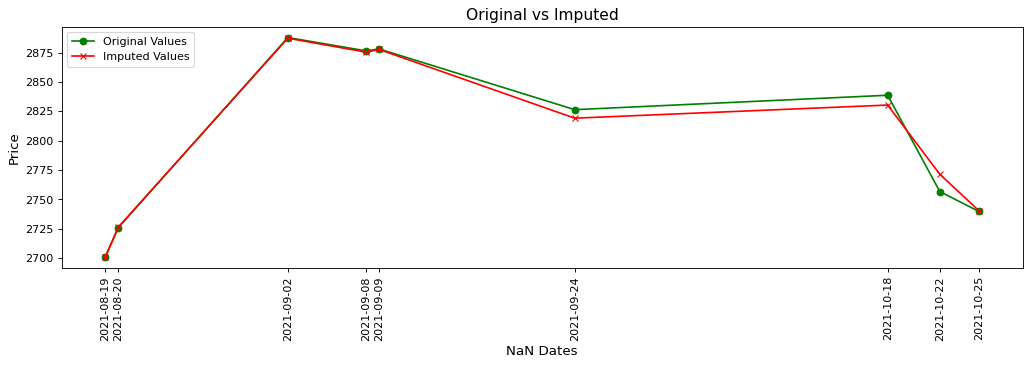

Time:   12:00:00
Total difference for current time: $27.83
Avg. difference for current time:  $3.09


Date,2021-08-06,2021-08-12,2021-08-16,2021-08-17,2021-09-16,2021-09-17,2021-09-21,2021-10-21,2021-10-25
the_nans,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
original_value,2715.50,2735.59,2722.45,2739.89,2859.32,2835.84,2791.84,2824.00,2739.11
imputed_value,2715.78,2736.93,2730.08,2739.78,2861.94,2836.02,2788.75,2827.22,2748.47
difference,0.28,1.34,7.63,-0.11,2.62,0.18,-3.09,3.22,9.36


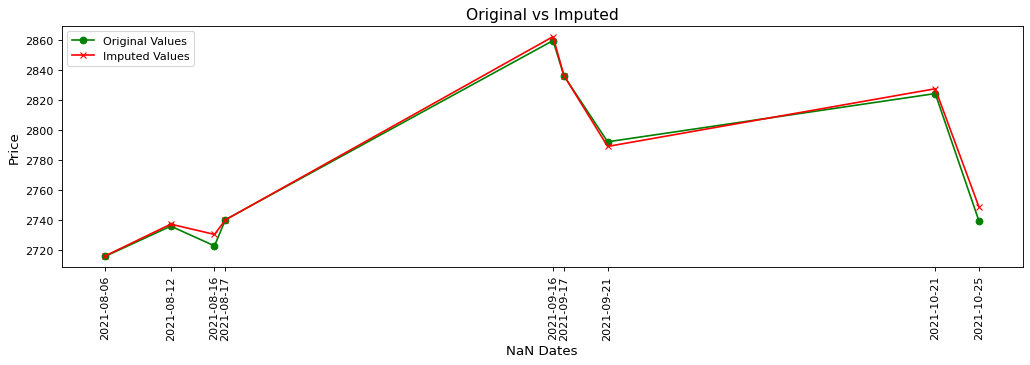

Time:   12:30:00
Total difference for current time: $25.81
Avg. difference for current time:  $2.87


Date,2021-08-06,2021-08-10,2021-08-17,2021-08-18,2021-09-03,2021-09-13,2021-09-20,2021-10-18,2021-10-19
the_nans,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
original_value,2711.81,2741.61,2740.89,2734.69,2878.93,2851.33,2752.06,2832.11,2861.29
imputed_value,2713.80,2736.33,2734.25,2733.96,2878.67,2846.72,2752.69,2836.43,2862.64
difference,1.99,-5.28,-6.64,-0.73,-0.26,-4.61,0.63,4.32,1.35


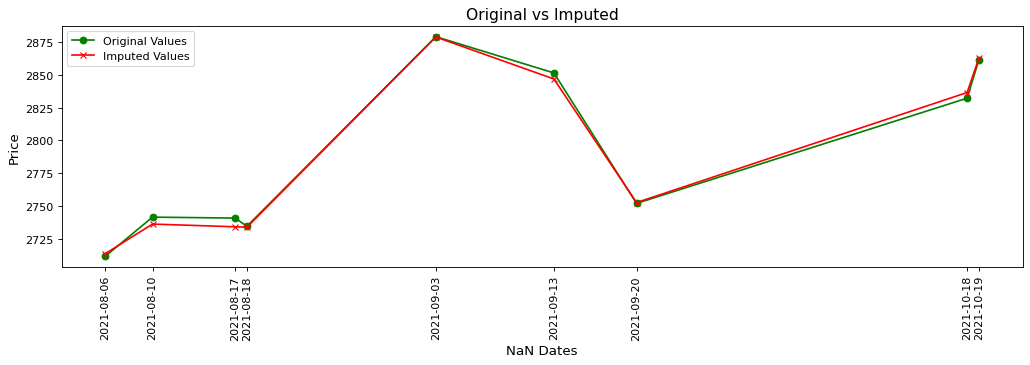

Time:   13:00:00
Total difference for current time: $35.7
Avg. difference for current time:  $3.97


Date,2021-08-09,2021-08-11,2021-08-17,2021-08-25,2021-09-14,2021-09-20,2021-09-21,2021-09-30,2021-10-20
the_nans,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
original_value,2719.90,2737.90,2723.13,2835.95,2850.55,2750.31,2786.70,2684.69,2837.97
imputed_value,2720.71,2732.33,2732.68,2835.76,2854.45,2758.11,2791.81,2684.13,2835.76
difference,0.81,-5.57,9.55,-0.19,3.90,7.80,5.11,-0.56,-2.21


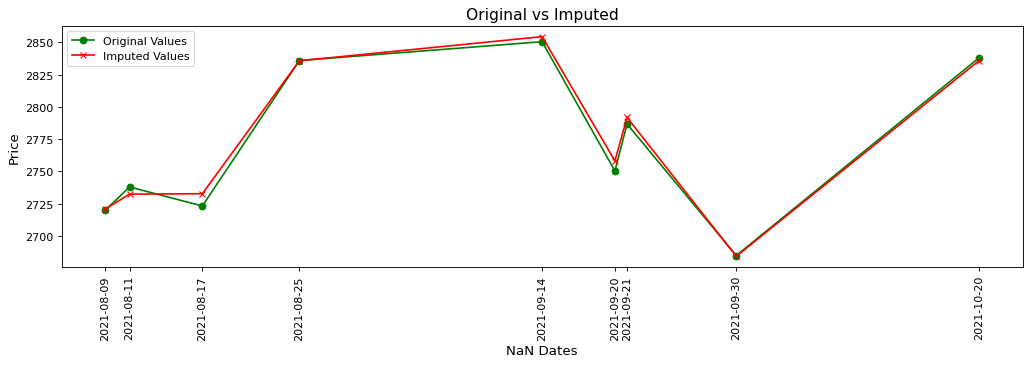

Time:   13:30:00
Total difference for current time: $30.6
Avg. difference for current time:  $3.4


Date,2021-08-04,2021-08-05,2021-08-25,2021-09-10,2021-09-21,2021-09-27,2021-09-29,2021-09-30,2021-10-07
the_nans,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
original_value,2711.00,2720.41,2834.89,2841.42,2779.34,2827.00,2688.59,2691.70,2797.64
imputed_value,2705.22,2717.86,2836.00,2838.30,2786.88,2824.29,2690.57,2688.66,2794.87
difference,-5.78,-2.55,1.11,-3.12,7.54,-2.71,1.98,-3.04,-2.77


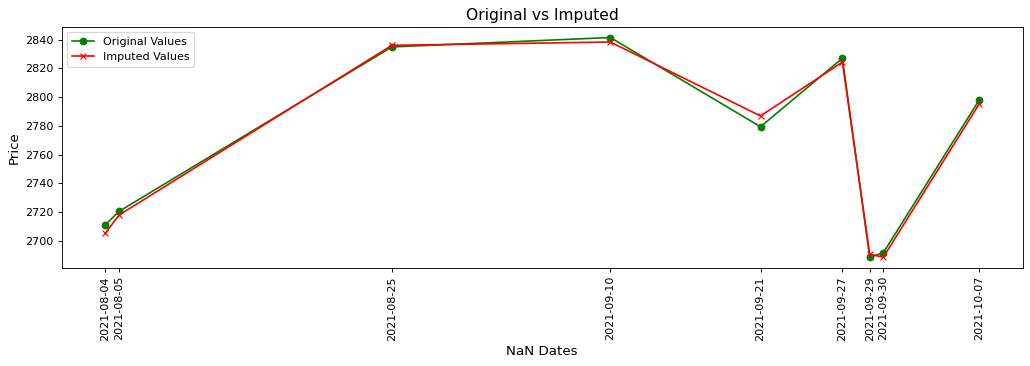

Time:   14:00:00
Total difference for current time: $20.87
Avg. difference for current time:  $2.32


Date,2021-08-10,2021-08-17,2021-09-07,2021-09-16,2021-10-05,2021-10-06,2021-10-12,2021-10-15,2021-10-18
the_nans,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
original_value,2744.98,2729.28,2878.63,2868.44,2739.31,2744.49,2720.35,2822.37,2843.57
imputed_value,2742.32,2729.98,2880.59,2866.37,2738.34,2741.57,2718.23,2827.19,2840.92
difference,-2.66,0.70,1.96,-2.07,-0.97,-2.92,-2.12,4.82,-2.65


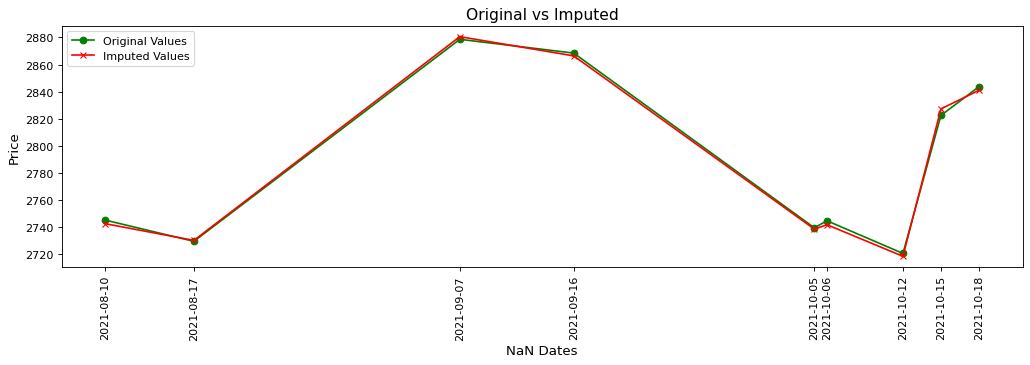

Time:   15:30:00
Total difference for current time: $44.5
Avg. difference for current time:  $4.94


Date,2021-08-04,2021-08-10,2021-09-07,2021-09-23,2021-09-24,2021-10-04,2021-10-05,2021-10-20,2021-10-25
the_nans,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
original_value,2704.91,2733.00,2882.70,2828.98,2837.87,2659.28,2729.82,2836.39,2746.43
imputed_value,2711.36,2742.87,2881.94,2830.00,2833.77,2665.19,2739.27,2838.46,2751.30
difference,6.45,9.87,-0.76,1.02,-4.10,5.91,9.45,2.07,4.87


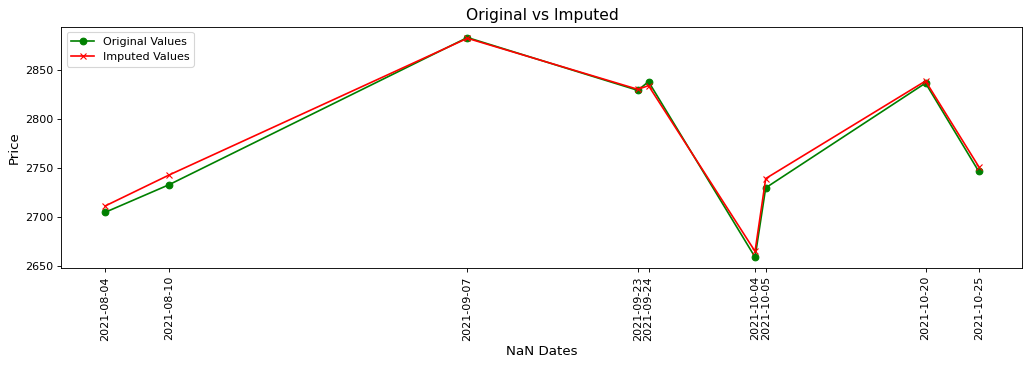

The overall difference is: $218.97
On an average, the imputer was $3.48 away from the actual value.


In [100]:
displayResults(adf, cdf, cdft)

#### 2.6.3 Understanding The Results<a id="2.6.3"></a>


The overall average difference was \\$3.48. This may seem like a lot if we're viewing this result as: "On an average, the imputations were \\$3.48 away from the actual value," but we must not forget to consider the average price of \\$GOOGL from our values in our original dataframe `adf`.

In [101]:
print(f"Of the {adf.count().sum()} prices in the original dataframe, `adf`, the average price is approximately ${adf.to_numpy().mean():.2f}.")

Of the 780 prices in the original dataframe, `adf`, the average price is approximately $2789.78.


If we divide the overall average difference by the average price, we get `3.48/2789.78 = 0.0012474101900508284`, which is no where near 1%. Investors wouldn't even mind risking 1% of their portfolio.

# 3. Thank You<a id="3"></a>
### 3.1 Final Words<a id="3.1"></a>
Thank you all for taking the time out of your day to read this notebook. Please don't forget to upvote if you think I deserve it.<br>
Feel free to play around with this notebook, I've pasted all the functions used in this notebook into one cell in the next section.

If you notice an error in my notebook, please reach out to me or leave a comment and I'll fix it so I don't mislead anyone.<br>
To me, any criticism is positive criticism, that's one of the best ways I learn.

<i>If you think I deserve a coffee</i>, please do buy me one by [clicking here](https://www.buymeacoffee.com/Gifari)! Any support helps me keep going.<br>
Be sure to follow me here on [GitHub](https://github.com/Gifari) and also on [Kaggle](https://www.kaggle.com/gifarihoque) where I'll be posting more notebooks and tutorials from time to time.<br>
Here is the link to my [Medium](https://gifari.medium.com/) account, where I'll also be posting tutorials and guides, please follow me there too.
Also, feel free to connect with me on [LinkedIn](https://www.linkedin.com/in/gifari/).

[Click here to check out my online portfolio!](https://gifari.github.io/)<br>

My other related works on Kaggle:<br>
[PIMA Indians Diabetes Database: Missing Data!? Where? A Machine Learning & IterativeImputer Tutorial (~86% Accuracy)](https://www.kaggle.com/gifarihoque/pidd-missing-data-ml-iterimputer-tut-86)<br><br>

> Although this notebook ends here, I hope you've got something out of this. Be sure to play around with the yfinance package as well, it's quite interesting what you can do with stock market data. I've been playing around with the data for some time now, and I'm always finding new things to do with the data. Many days of writing and research went into this notebook and my [Medium article](https://gifari.medium.com/a-better-way-to-handle-missing-values-in-your-dataset-using-iterativeimputer-9e6e84857d98). Hopefully this notebook along with my article inspired at least one of you with an idea or something to do greater things in your life.
> 
> <i>Let this ending, be a new beginning for you.</i>
> 
> As always, thanks again for stopping by.

### 3.2 All Functions<a id="3.2"></a>
<b>Expand the cell below to see all functions.</b>



In [102]:
# First
def splitDataByDates(df):
    """
    Description
    -----------
    This function will split the dataframe returned by `yfinance` by days. 
    For example, if your `period` was set to "60d", then you'll get 60
    individual dataframes which will be stored in `the_data`.
    
    NOTE: 
    Use this function only when you have set an `interval` to an 
    intraday value. 
    Valid intraday intervals are: 1m, 2m, 5m, 15m, 30m, 60m,and 90m.
    
    Parameters
    ----------
    df (dataframe):
        The dataframe returned from yfinance.
    
    Returns
    -------
    the_dates (list):
        A list of all the dates in the dataframe returned from yfinance.
    
    the_data (list of dataframes):
        A list of dataframes. Each date will have it's own dataframe.
        
    """
    # The returned lists
    the_dates = []
    the_data = []
    
    # Splits the data retrieved from yfinance by date
    for group in df.groupby(df.index.date):
        the_dates.append(group[0])
        the_data.append(group[1])
    return the_dates, the_data



# Second
def makeTimesDict(the_data):
    """
    Description
    -----------
    This will create an empty dictionary and set the keys equal to
    all the time interval in the `Datetime` index of `the_data`,
    which was retrieved after running `splitDataByDates()`.
    This will also give the created dictionary a 'Date' key to hold
    all of the dates. This dictionary is required if you've retrieved
    data from yfinance with an intraday interval.
    
    Parameters
    ----------
    the_data (list of dataframes):
        The list of dataframes which was retrieved after running the
        function `splitDataByDates()`.
    
    Returns
    -------
    adict (dict):
        A dictionary with the appropriate keys.
        
    """
    # Create an empty dictionary
    adict = {}
    # Give dictionary a 'Date' key
    adict['Date'] = []
    
    # For every time listed in the index of each dataframes in`the_data`,
    # make that time a key for the dictionary.
    for i in the_data[0].index:
        adict[str(i.time())] = []
    return adict



# Third
def appendValues(adict, the_dates, the_data, use='Close'):
    """
    Description
    -----------
    This will append the appropriate values from each dataframe
    in `the_data` to the dictionary `adict` based on the `use`
    case. The default use case is 'Close'. This will also append 
    the dates from `the_dates` to the dictionary.
    
    Parameters
    ----------
    adict (dict):
        The dictionary with set keys retrieved after running
        the function `makeTimesDict()`.
    
    the_dates (list):
        The list of dates retrieved after running the function
        `splitDataByDates()`.
        
    the_data (list of dataframes):
        The list of dataframes which was retrieved after running
        the function `splitDataByDates()`.
    
    use (str):
        The column from the data returned from yFinance of which 
        you want to retrieve data from. The valid `use` cases
        are: 'Open', 'High', 'Low', or 'Close'.
        The default `use` case is set to 'Close'.
        
    Returns
    -------
    Nothing.
    
    Examples
    --------
    `appendValues(dic, dates, data, use='Open')` will append all
    "Open" values from `data` to `dic`, and will append all dates
    from the list `dates` to `dic`.
    
    """
    # If invalid `use` case is given, a print statement will be returned instead
    if use not in ['Open', 'High', 'Low', 'Close']:
        print(f'{use} was not a valid use case, a valid use case would be one of the four:')
        print('\t- "Open"\n\t- "High"\n\t- "Low"\n\t- "Close"')
        print('Note: The default use case is "Close", if you don\'t specify a use case, the default will be used.')
    # If valid `use` case is given, function will carry on
    else:
        # Append all dates from `the_dates` to `adict`
        for date in range(len(the_dates)):
            adict['Date'].append(the_dates[date])
            # Append all appropriate values from `the_data` to the corresponding `adict` keys
            for i, time in enumerate(list(adict.keys())[1:]):
                adict[time].append(round(the_data[date][use][i], 2))
                
                
                
# Fourth
def replaceWithNan(df, noOfCols, percOfNulls):
    """
    Description
    -----------
    This will randomly choose `noOfCols` columns and will randomly
    choose `percOfNulls` percent of the rows in each chosen column
    to replace the value of with NaN for a given dataframe `df`.
    
    Parameters
    ----------
    df (dataframe):
        The dataframe after converting the dictionary retrieved
        after calling function `appendValues()`.
    
    noOfCols (int):
        The number of columns you wish to randomly choose for
        NaN replacement.
    
    percOfNulls (int or float):
        The percentage of values in each chosen column that you
        want to replace with NaN.
        
    Returns
    -------
    ndf (dataframe):
        The dataframe with NaN replacements.
        
    Examples
    --------
    `cdf = replaceWithNan(adf, 4, 25)` choose 4 columns at random
        and will choose 25% of the values to replace with NaN.
    `cdf = replaceWithNan(adf, 7, 101)` will cause the machine to
        be confused af, and `cdf` will be `NoneType`.
    `cdf = replaceWithNan(adf, 10000, .15)` will display a message
        saying that there aren't enough columns.
    """
    # If percentage is greater than 100%, then this won't work
    if percOfNulls > 100:
        print("You're probably asking to make more than the whole column null.")
        print("Why so confuse me? I am only machine! :(")
    # If the number of columns specified is more than the number of columns available,
    # then this print statement will be displayed
    elif noOfCols > len(df.columns):
        print(f"There are only {len(df.columns)} columns in your dataframe, but you're telling me to choose {noOfCols} columns.")
        print(f"If you want me to choose ALL columns, please set 'noOfCols' equal to {len(df.columns)}.")
    else:
        # If `percOfNulls` >=1, it will be assumed that `percOfNulls` is out of 100
        if percOfNulls >= 1:
            percOfNulls = percOfNulls/100
        # Make deep copy of original dataframe
        ndf = df.copy(deep = True)
        # For every randomly chosen column, replace `percOfNulls` percent of the values with NaN
        for column in ndf.sample(noOfCols, axis = 1):
            ndf[column] = ndf[column].sample(frac = 1 - percOfNulls)
        return ndf
    
    
    
# Fifth
def imputeMissingVals(ndf, imputer = IterativeImputer()):
    """
    Description
    -----------
    This will impute the NaNs in dataframe `ndf` with 
    `IterativeImputer()`. If `imputer` is invalid, an error will
    be displayed along with the error description. If no imputer
    is specified in the function, the function will use the
    default imputer, `IterativeImputer()` with no specific
    parameters. The default estimator used for the imputer is
    `BayesianRidge()`.
    
    Parameters
    ----------
    ndf (dataframe):
        The dataframe containing NaNs, which was retrieved from
        function `replaceWithNan()`.
    
    imputer (IterativeImputer()):
        `IterativeImputer()` with any parameters of your choice.
    
    Returns
    -------
    ndft (dataframe):
        A dataframe with the imputed values.
        
    """
    # If `imputer` is invalid, an error will be thrown
    try:
        imputer.fit(ndf)
    except Exception as e:
        print("============================================================================")
        print(f"I wasn't able to iteratively impute with the given imputer:\n{str(imputer)}.")
        print(f"This was the error I've received from my master:\n\n{e}.")
        print("\nNOTE:\n\tAn imputer is already given by default for this function.")
        print("\tIf you don't set `imputer` to anything, then the default")
        print("\t`IterativeImputer()` with no other parameters will be used.")
        print("\tThe default estimator for `IterativeImputer()` is `BayesianRidge()`.")
        print("============================================================================")
    # If `imputer` is valid, then the imputer will fit to the dataframe containing NaNs and transform
    # A dataframe `ndft` will then be returned which contains the imputed values
    else:
        imputer.fit(ndf)
        ndft = pd.DataFrame(imputer.transform(ndf), columns = ndf.columns, index = ndf.index)
        
        return ndft
    
    
    
# Sixth
def displayResults(original_df, null_df, imputed_df, showDF = True, showGraph = True):
    """
    Description
    -----------
    This will display how far/close the imputed values were to
    the original values. Each column that was randomly chosen
    after running the function `replaceWithNan()` was a 
    certain "time". For however many columns chosen, there will
    be that many dataframes created for comparison purposes.
    So basically, every column ("time") that has a NaN value in
    `null_df` will have it's own set of results which will be
    separated by a border: "===========".
    
    In each separation, there will be a dataframe of 4 rows.
    Each separation is it's own "time", and each separation
    will have different dates that were replaced by NaNs for
    the specific "time".
    So this means, a specific ("time", "date") pair was NaN.
    The first row is a row containing only NaNs from the
    dataframe `null_df`. 
    The second row contains the original value for that given
    ("time", "date") pair.
    The third row contains the imputed value for that given
    pair.
    The fourth row contains the difference between the imputed
    and the original value.
    If the difference is positive, then it was an overestimation
    by the amount.
    If the difference is negative, the imputer underestimated
    the original value by the amount.The absolute value of the
    "differences" will be added up for each separation and will
    be displayed in each separation. The average difference
    will also be displayed in each separation. The average
    difference basically states that "for this current time, on
    an average, this was how far off the imputed value were from the 
    original values." The overall average in difference will also be 
    tracked to be displayed in the end along with the overall difference.
    A graph will also be displayed showing the difference between
    the original value and the imputed value for only the dates
    which were NaN for the current time in `null_df`.
    
    Parameters
    ----------
    original_df (dataframe):
        The original dataframe without any NaN replacements.
        This is the dataframe after converting the dictionary
        retrieved after calling the function `appendValues()`.
        
    null_df (dataframe):
        The dataframe after NaN replacements.
        This is the dataframe retrieved after calling the
        function `replaceWithNan()`.
        
    imputed_df (dataframe):
        The dataframe after imputations.
        This is the dataframe retrieved after calling the
        function `imputeMissingVals()`.
        
    showDF (bool):
        If True, then the dataframe containing the 4 rows
        will be displayed along with the other results.
        This is set to True by default.
    
    showGraph (bool):
        If True, then a graph will be displayed showing the
        original vs. imputed value.
        This is set to True by default.
    
    Returns
    -------
    Nothing.
    
    """
    # Keep track of the overall difference
    overallDifference = 0
    # Keep track of the overall average in difference
    overallAvg = 0
    
    cols = null_df.columns[null_df.isna().any()].tolist()
    for time in cols:
        
        # `currentDifference` will be used to display the overall difference for the current dataframe ("time")
        currentDifference = 0
        # `currentAvg` will be used to display the overall average in difference for the current dataframe ("time")
        currentAvg = 0

        # Print which "time" column we're dealing with
        print(f'Time:   {time}')

        # Create dataframe `somedf`, which contains 4 rows:
           # cdf[time]                         --> first row will have all values in our dataframe replaced with NaNs for the current "time" (index = 'the_nans')
           # adf[time]                         --> second row will have all values in our original dataframe for the current "time" (index = 'original_value')
           # round(cdft[time], 2)              --> third row will have all values (rounded) in our imputed dataframe for the current "time" (index = 'imputed_value')
           # round(cdft[time], 2) - adf[time]] --> fourth row will display the difference in imputed value to original value for the current "time" (index = 'difference')
             # Note: If difference is negative, that means the imputer underestimated the original value, if difference is positive, the imputer overestimated the original
        somedf = pd.DataFrame([null_df[time], original_df[time], round(imputed_df[time], 2), round(imputed_df[time], 2) - original_df[time]], index = ['the_nans', 'original_value', 'imputed_value', 'difference'])

        
        # Make the differences absolute value, and sum up the differences to get the total difference for the current "time"
        currentDifference = round(somedf.loc['difference'].abs().sum(), 2)
        print(f'Total difference for current time: ${currentDifference}')

        # It's like an OnlyFans but for `onlyNans` 
        onlyNans = somedf.loc[:, somedf.isna().any()]
        # Set `currentAvg` to the average of the absolute values of the differences
        currentAvg = round(onlyNans.loc['difference'].abs().mean(), 2)
        # Update `overallAvg`
        overallAvg += currentAvg
        print(f"Avg. difference for current time:  ${currentAvg}")
        
        if (showDF):
            # Display dataframe of ONLY the dates containing NaNs for easier comparison
            display(onlyNans)
            
        if (showGraph):
            # Display a chart showing the difference between the original values
            # and the imputed values of ONLY the values which were NaNs 
            plt.figure(figsize=(15.5, 4), dpi=80)
            plt.plot(onlyNans.loc['original_value'], color = 'green', marker = 'o', label="Original Values")
            plt.plot(onlyNans.loc['imputed_value'], color = 'red', marker = 'x', label="Imputed Values")
            plt.xticks(onlyNans.columns,rotation = 'vertical')
            plt.xlabel('NaN Dates', fontsize=12)
            plt.ylabel('Price', fontsize=12)
            plt.title('Original vs Imputed', fontsize=14)
            plt.legend(loc="upper left")
            plt.show()

        # Update the overall difference
        overallDifference += currentDifference
        print('==============================================================================================================================================')

    # Print the overall difference, which is a measurement to determine how "off" the imputer was
    print(f'The overall difference is: ${round(overallDifference, 2)}')
    print(f'On an average, the imputer was ${round(overallAvg/len(cols), 2)} away from the actual value.')

### 3.3 References<a id="3.3"></a>

[It doesn't matter image](https://memegenerator.net/img/instances/67036946/it-doesnt-matter-what-your-opinion-is.jpg)<br>
[IterativeImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html)<br>
[My Medium article]()<br>
[Python round() function](https://docs.python.org/3/library/functions.html#round)<br>
[yfinance documentation](https://aroussi.com/post/python-yahoo-finance)